In [1]:
# Homework 2 Question 3
# This code was adapted from the python file "06-quasilinear-advection-linear.py"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Smooth initial condition
def gaussian(x):
    return np.exp(-100 * (x - 0.25)**2)

# Non-smooth initial condition
def step(x):
    return np.where((x >= 0.2) & (x <= 0.4), 1.0, 0.0)

# Minmod function
def minmod(a, b):
    c = 0 * a
    for i in range(len(a)):
        if a[i] * b[i] > 0:
            if abs(a[i]) <= abs(b[i]):
                c[i] = a[i]
            else:
                c[i] = b[i]
        else:
            c[i] = 0.0
    return c

# Lax-Wendroff update with minmod slope limiter
def lw_minmod_update(u, ht, hx, a):
    J = np.arange(len(u))
    Jm1 = np.roll(J, 1)
    Jp1 = np.roll(J, -1)

    # Compute slopes
    sigm = (u - u[Jm1]) / hx
    sigp = (u[Jp1] - u) / hx
    sigma = minmod(sigm, sigp)

    return u - (a * ht / hx) * (u - u[Jm1]) \
             - (a * ht / (2.0 * hx)) * (sigma - sigma[Jm1]) * (hx - a * ht)

# Grid norm function for computing the discrete L2 norm
def grid_norm(u, hx):
    return np.sqrt(np.sum(u**2) * hx)

def solve_advection(u_init, T, nx, gamma=0.95, a=1.0):
    x, hx = np.linspace(0, 1, nx, endpoint=False, retstep=True)
    ht = hx * gamma / a
    nt = int(np.ceil(T / ht))
    ht = T / nt

    u = u_init(x)

    for _ in range(nt):
        u = lw_minmod_update(u, ht, hx, a)

    # For the advection equation the initial solution simply shifts with wavespeed a
    u_exact = u_init((x - a * T) % 1)

    # Calculate the L2 error using the grid norm
    L2_error = grid_norm(u - u_exact, hx)

    return x, u, u_exact, L2_error


In [4]:

T = 1.0      # End time
gamma = 0.99 # High gamma to show the order clearly
a = 1.0      # Advection wave speed
nx_values = [8, 16, 32, 64, 128, 256]  # Grid refinement study

errors_smooth = []
errors_step = []
hs = []

print("Convergence Study:")
print("nx     hx           L2 error (Smooth)    Order (Smooth)    L2 error (Step)    Order (Step)")
order_smooth = []
order_step = []

prev_error_smooth = None
prev_error_step = None
prev_h = None

# Dictionaries to store final time solutions for later plotting
results_smooth = {}
results_step = {}

for nx in nx_values:
    x, u_num, u_ex, err_smooth = solve_advection(gaussian, T, nx, gamma, a)
    _, u_num_step, u_ex_step, err_step = solve_advection(step, T, nx, gamma, a)

    hs.append(1.0/nx)
    errors_smooth.append(err_smooth)
    errors_step.append(err_step)

    # Save final time solutions for plotting later
    results_smooth[nx] = (x, u_num, u_ex)
    results_step[nx] = (x, u_num_step, u_ex_step)

    if prev_error_smooth is None:
        order_str_smooth = "N/A"
        order_str_step = "N/A"
    else:
        order_val_smooth = np.log(err_smooth/prev_error_smooth) / np.log((1.0/nx)/(prev_h))
        order_val_step = np.log(err_step/prev_error_step) / np.log((1.0/nx)/(prev_h))
        order_str_smooth = f"{order_val_smooth: .2f}"
        order_str_step = f"{order_val_step: .2f}"
        order_smooth.append(order_val_smooth)
        order_step.append(order_val_step)

    print(f"{nx:4d}  {1.0/nx:10.3e}    {err_smooth:14.4e}       {order_str_smooth:>6s}       {err_step:14.4e}       {order_str_step:>6s}")

    prev_error_smooth = err_smooth
    prev_error_step = err_step
    prev_h = 1.0/nx

Convergence Study:
nx     hx           L2 error (Smooth)    Order (Smooth)    L2 error (Step)    Order (Step)
   8   1.250e-01        1.8144e-01          N/A           1.7999e-01          N/A
  16   6.250e-02        4.9383e-02         1.88           1.2390e-01         0.54
  32   3.125e-02        1.1132e-02         2.15           8.7639e-02         0.50
  64   1.562e-02        2.3055e-03         2.27           6.2257e-02         0.49
 128   7.812e-03        7.6866e-04         1.58           5.3036e-02         0.23
 256   3.906e-03        1.9855e-04         1.95           4.1390e-02         0.36


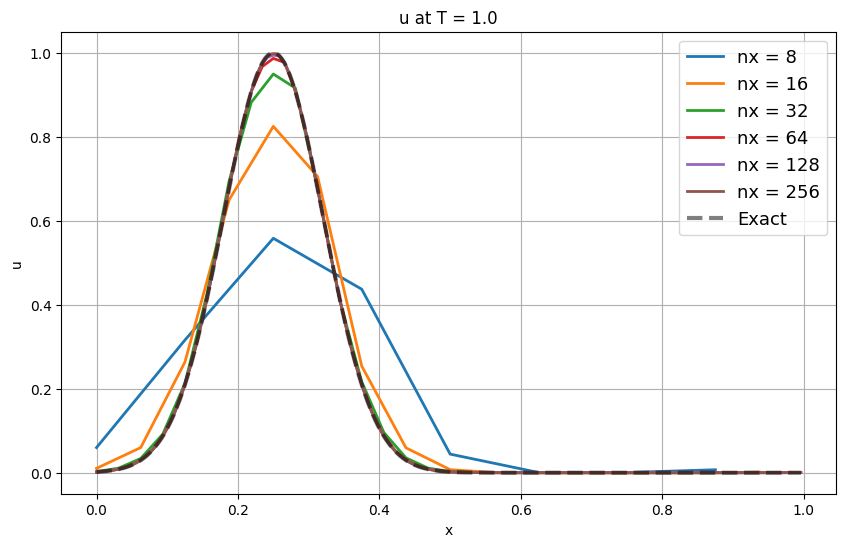

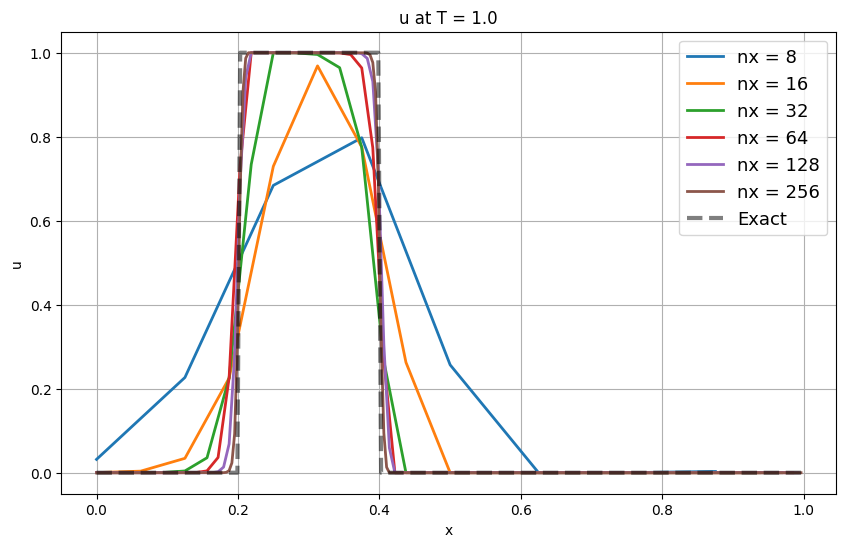

In [5]:

# Smooth plot
plt.figure(figsize=(10,6))
for nx in nx_values:
    x, u_num, u_ex = results_smooth[nx]
    plt.plot(x, u_num, label=f"nx = {nx}", linewidth=2)
plt.plot(x, u_ex, 'k--', linewidth=3, label='Exact', alpha=0.5)
plt.title(f"u at T = {T}")
plt.xlabel("x")
plt.ylabel("u")
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("smooth_solution.png",dpi=300)
plt.show()


# Non-smooth plot
plt.figure(figsize=(10,6))
for nx in nx_values:
    x, u_num_step, u_ex_step = results_step[nx]
    plt.plot(x, u_num_step, label=f"nx = {nx}", linewidth=2)
plt.plot(x, u_ex_step, 'k--', linewidth=3, label='Exact', alpha=0.5)
plt.title(f"u at T = {T}")
plt.xlabel("x")
plt.ylabel("u")
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("non_smooth_solution.png",dpi=300)
plt.show()
